In [73]:
#Это единый пайплайн моего диплома

In [74]:
from PIL import Image
import tensorflow as tf
import scipy.ndimage
from scipy import misc
from scipy.interpolate import RectBivariateSpline
import numpy as np
import numpy.matlib as ml
import random
import time
import os
import gc
import scipy.io
tf.reset_default_graph()
slim = tf.contrib.slim
sess = tf.InteractiveSession()
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


#### Дальше загрузка параметров

In [75]:
num_out = 5    #number ouf output parameters being predicted
global numpix_side
numpix_side = 192   #number of image pixels on the side

global pix_res
pix_res = 0.04 # pixel size in arcsec
L_side = pix_res * numpix_side

In [76]:
global max_noise_rms, max_psf_rms , max_cr_intensity
max_trainoise_rms = 0.1 # maximum rms of noise in training data
max_testnoise_rms = 0.1 # maximum rms of noise in test or validation data
max_noise_rms = max_testnoise_rms

max_psf_rms = 0.08/0.04  # maximum Gaussian PSF rms (in pixels)
max_cr_intensity = 0.5 # maximum scaling for cosmic ray and artefact maps

global constant_noise_rms
variable_noise_rms = True  #if True, the noise rms will be chosen
#randomly for each sample with a max of max_noise_rms (above)

global min_unmasked_flux
min_unmasked_flux = 0.75

# xy range of center of the lens. The image is shifted 
# in a central area with a side of max_xy_range (arcsec) during training or testing
global max_xy_range   
max_xy_range = 0.5

In [77]:
cycle_batch_size = 50   # how many examples to read at a time (here it's equal to the batch size)
num_test_samples = 200 # number of test samples

num_training_samples = 200
max_num_test_samples = 200

In [91]:
global arcs_data_path_1, arcs_data_path_2 , test_data_path_1 , test_data_path_2 , CRay_data_path
global lens_data_path_1, lens_data_path_2, testlens_data_path_1, testlens_data_path_2

global num_data_dirs
num_data_dirs = 1

arcs_data_path_1 = '../2. Making lensed/lensed_images/'
arcs_data_path_2 = arcs_data_path_1
arcs_data_path_3 = arcs_data_path_1
test_data_path_1 = '../2. Making lensed/lensed_images/'
test_data_path_2 = test_data_path_1
test_data_path_3 = test_data_path_1

lens_data_path_1 = '../2. Making lensed/lensed_images/'
lens_data_path_2 = lens_data_path_1
lens_data_path_3 = lens_data_path_1
testlens_data_path_1 = '../2. Making lensed/lensed_images/'
testlens_data_path_2 = testlens_data_path_1
testlens_data_path_3 = testlens_data_path_1

#CRay_data_path   = 'C:/Users/fedor/For jupyter/Ensai/data_Ensai/CosmicRays/'

### Создание Placholder-ов

In [79]:
x = tf.placeholder(tf.float32, shape=[None, numpix_side*numpix_side])   #placeholder for input image
y_ = tf.placeholder(tf.float32, shape=[None,num_out])    #placeholder for output parameters during training
x_image0 = tf.reshape(x, [-1,numpix_side,numpix_side,1])

In [80]:
# removing image intensity bias: filter image with a 4X4 filter and remove from image
MASK = tf.abs(tf.sign(x_image0))
XX =  x_image0 +  ( (1-MASK) * 200.0)
bias_measure_filt = tf.constant((1.0/8.0), shape=[4, 4, 1, 1])
bias_measure = tf.nn.conv2d( XX , bias_measure_filt , strides=[1, 1, 1, 1], padding='VALID')
im_bias = tf.reshape( tf.reduce_min(bias_measure,axis=[1,2,3]) , [-1,1,1,1] )
x_image = x_image0 - (im_bias * MASK )

In [81]:
x_image0

<tf.Tensor 'Reshape:0' shape=(?, 192, 192, 1) dtype=float32>

In [82]:
MASK

<tf.Tensor 'Abs:0' shape=(?, 192, 192, 1) dtype=float32>

### Моделирование

In [83]:
# construct all models (networks):
exec(open("ensai_model.py").read())

In [84]:
# make an instance of AlexNet (model 9):
with tf.variable_scope("ENSAI"):
    y_conv = model_9(x_image,scope="EN_Model9")

In [85]:
variables_to_restore =  slim.get_variables(scope="ENSAI/EN_Model9" )   #list of variables to restore
restore_file = "../data_Ensai/trained_weights/model_9.ckpt"
restorer = tf.train.Saver(variables_to_restore)
 
sess.run(tf.global_variables_initializer())      #initialize variables
restorer.restore(sess, restore_file)             # restore our saved weights

INFO:tensorflow:Restoring parameters from ../data_Ensai/trained_weights/model_9.ckpt


In [86]:
MeanSquareCost , y_conv_flipped = cost_tensor(y_conv)

In [87]:
exec(open("get_data.py").read())

In [88]:
# read some lens image files from the disk and add observational effects to them:

max_xy_range = 0.5  # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
variable_noise_rms = True   #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms
max_noise_rms = 0.1  # maximum rms of noise data
num_samp = 200   #number of test samples
chunk_size = 50    # batch number: how many test examples to pass at one time.

X = np.zeros( ( num_samp , numpix_side * numpix_side ), dtype='float32') ;   #numpy array holding the images
Y = np.zeros( ( num_samp , num_out ) , dtype='float32' );                    #numpy array holding the lens parameters (here only used to flip for the x-y ellipticity)
Predictions = np.zeros( ( num_samp , num_out ) , dtype='float32' );          #predicted parameters
mag = np.zeros((num_samp,1))

In [90]:
read_data_batch( X , Y , mag , num_training_samples  , 'train')             #read data

200


In [69]:
cost = 0.0
ind_t = range(num_samp)
sum_rms = 0
num_chunks = num_samp/chunk_size

#loop over our samples (since we can't give all the test data at once because of limited gpu memory)
for it in range(int(num_chunks)):
        print(it)
        xA = X[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]] 
        yA = Y[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]
        cost  = cost + sess.run(MeanSquareCost, feed_dict={x: xA, y_: yA})   # evaluate cost
        A = sess.run(y_conv , feed_dict={ x: xA})   # A is the network prediction for parameters
        B = sess.run(y_conv_flipped , feed_dict={ x: xA})  # B is the same prediction with the ellipticity flipped
        Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]  = get_rotation_corrected(A,B,Y[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])  # "Prediction" is now corrected for the flip.
        sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] - Y[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
        print('rms error is ' + np.array_str( sum_rms/(it+1)  ,precision=2))

0
rms error is [0.84 0.34 0.37 0.12 0.1 ]
1
rms error is [0.86 0.36 0.38 0.1  0.1 ]
2
rms error is [0.93 0.36 0.39 0.11 0.09]
3
rms error is [0.97 0.34 0.39 0.1  0.08]


Text(0.5, 0, 'y (true)')

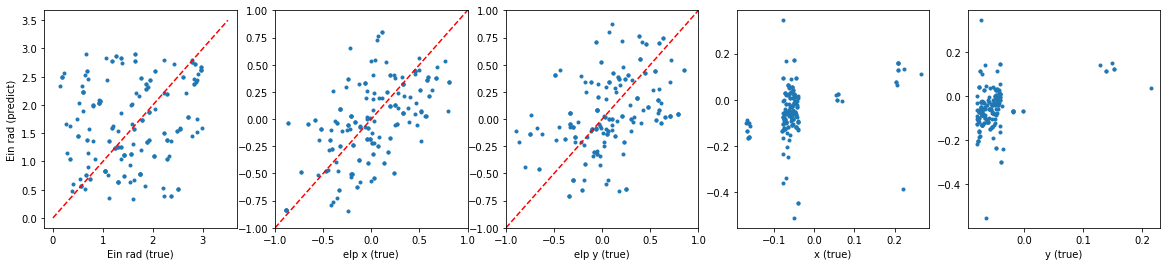

In [72]:
# And here's the fun part:
# plot the recovered parameters (y-axis) against their true values (x-axis)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(Y[:,0],Predictions[:,0],' .')
plt.plot([0 , 3.5],[0 , 3.5],'--r')
plt.xlabel("Ein rad (true)")
plt.ylabel("Ein rad (predict)")
#plt.axis([0 ,3 ,0 ,3])

plt.subplot(1, 5, 2)
plt.plot(Y[:,1],Predictions[:,1],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp x (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 3)
plt.plot(Y[:,2],Predictions[:,2],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp y (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 4)
plt.plot(Y[:,3],Predictions[:,3],' .')
#plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("x (true)")
#plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])


plt.subplot(1, 5, 5)
plt.plot(Y[:,4],Predictions[:,4],' .')
#plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("y (true)")
#plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])

In [ ]:
# Show a few example of the lenses
plt.figure(figsize=(20, 20))
for i in range(1, 16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[[i]].reshape(numpix_side,numpix_side),vmin=-0.15,vmax=1.0,cmap='nipy_spectral')